In [13]:
# New model : https://medium.com/analytics-vidhya/text-classification-using-word-embeddings-and-deep-learning-in-python-classifying-tweets-from-6fe644fcfc81
"""
THis model was inspired from theis website and part of the code from the website has been used here. 
https://medium.com/analytics-vidhya/text-classification-using-word-embeddings-and-deep-learning-in-python-classifying-tweets-from-6fe644fcfc81
"""


from scipy.sparse import *
import numpy as np
!pip3 install pickle5
import pickle5 as pickle
import random
from sklearn import svm
import sklearn
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
# Deep learning: 
from keras.models import Input, Model
from keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional


# For accuracy calculations
from sklearn.metrics import accuracy_score






     |████████████████████████████████| 256 kB 4.1 MB/s 


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
class RnnModel():
    """
    A recurrent neural network for semantic analysis
    """

    def __init__(self, embedding_matrix, embedding_dim, max_len, X_additional=None):
        
        inp1 = Input(shape=(max_len,))
        x = Embedding(embedding_matrix.shape[0], embedding_dim, weights=[embedding_matrix], trainable=False)(inp1)
        #x = SpatialDropout1D(0.2)
        #x = Bidirectional(LSTM(256, return_sequences=True))(x)
        x = LSTM(128, return_sequences=True)(x)
        #x = BatchNormalization()(x)
        x = Dropout(0.2)(x)
        x = LSTM(64)(x)
        #x = BatchNormalization()(x)
        #x = LSTM(128)(x)
        x = Dropout(0.2)(x)
        #x = Dense(128, activation="relu")(x)
        x = Dense(64, activation="relu")(x)
        #x = BatchNormalization()(x)
        x = Dropout(0.1)(x)
        x = Dense(32, activation="relu")(x)
        #x = BatchNormalization()(x)
        x = Dropout(0.1)(x)
        x = Dense(1, activation="sigmoid")(x)    
        model = Model(inputs=inp1, outputs=x)

        model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
        model.summary()
        self.model = model

In [4]:
class TextToTensor():

    def __init__(self, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.max_len = max_len

    def string_to_tensor(self, string_list: list) -> list:
        """
        A method to convert a string list to a tensor for a deep learning model
        """    
        string_list = self.tokenizer.texts_to_sequences(string_list)
        string_list = pad_sequences(string_list, maxlen=self.max_len)
        
        return string_list



In [14]:
class Pipeline:
    """
    A class for the machine learning pipeline
    """
    def __init__(
        self, 
        X_train: list, 
        Y_train: list, 
        embed_dim: int,
        max_len=0,
        epochs=3,
        batch_size=256,
        num_words=[]
        ):

        with open('drive/MyDrive/ML_project/ML_proj_final/tokenizer.pickle','rb') as f:  # path where you save the tokenizer 
          tokenizer = pickle.load(f)

        embedding_matrix=np.load('drive/MyDrive/ML_project/ML_proj_final/embeddings_matrix_lem_200_twi.npy') # path where you save your embedding mqtrix

        Y_train = np.asarray(Y_train)

       
        
        # Creating the padded input for the deep learning model
        print('Creating the padded input for the deep learning model')
        if max_len==0:
            max_len = np.max([len(text.split()) for text in X_train])
        TextToTensor_instance = TextToTensor(
            tokenizer=tokenizer, 
            max_len=max_len
            )
        X_train = TextToTensor_instance.string_to_tensor(X_train)

        
        # Creating the model
        print('Creating the model')
        rnn = RnnModel(
            embedding_matrix=embedding_matrix, 
            embedding_dim=embed_dim, 
            max_len=max_len
        )
        self.history=rnn.model.fit(
            X_train,
            Y_train, 
            validation_split=0.2,
            batch_size=batch_size, 
            epochs=epochs
        )
        
        self.model = rnn.model

        # Test our model :
        print('Test our model')
        yhat_tr = [x[0] for x in rnn.model.predict(X_train).tolist()]


        rnn.model.save('modelfull3') # name of our model 
        acc = accuracy_score(Y_train, [1 if x > 0.5 else 0 for x in yhat_tr])
        print(acc)

In [15]:
X_train_pos=[]
Y_train_pos=[]
print('get data')
f_pos=open('drive/MyDrive/ML_project/ML_project/train_pos_full_lem.txt',encoding ="latin-1") # path for the pos train preprocessed
for line in f_pos:
    X_train_pos.append(line.strip())
    Y_train_pos.append(1)

X_train_neg=[]
Y_train_neg=[]
f_neg=open('drive/MyDrive/ML_project/ML_project/train_neg_full_lem.txt')                    # path for the neg train preprocessed
for line in f_neg:
    X_train_neg.append(line.strip())
    Y_train_neg.append(0)


X_train=X_train_pos+X_train_neg
Y_train=Y_train_pos+Y_train_neg
Y_train=Y_train

X_test=[]
f_test=open('drive/MyDrive/ML_project/ML_project/test_data_lem.txt')                        # path for the test dataset preprocessed
for line in f_test:
    X_test.append(line.strip())
    

# shuffle the data : 
import random
random.seed(10)

data = list(zip(X_train, Y_train))

random.shuffle(data)

X_train, Y_train = zip(*data)



max_len = 20

results = Pipeline(
X_train=X_train,
Y_train=Y_train,
embed_dim=200,  # choose the embed dim in function of the embedded matrix size 
max_len=max_len,
epochs=5,
batch_size=256,
)

get data
I AM HERE 
Creating the padded input for the deep learning model
Creating the model
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 embedding (Embedding)       (None, 20, 200)           40000200  
                                                                 
 lstm (LSTM)                 (None, 20, 128)           168448    
                                                                 
 dropout (Dropout)           (None, 20, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                  

INFO:tensorflow:Assets written to: modelfull3/assets


INFO:tensorflow:Assets written to: modelfull3/assets


0.8731132
[0.0001872795692179352, 0.385628879070282, 0.30685460567474365, 0.8582578301429749, 0.03347320854663849, 0.5205292701721191, 0.29140332341194153, 0.9799278974533081, 0.8090763688087463, 0.9636069536209106, 0.9720228910446167, 0.8674602508544922, 0.6109023690223694, 0.27202698588371277, 0.9721234440803528, 0.9569315314292908, 4.5174683691584505e-06, 0.9998065829277039, 0.9930797219276428, 1.5026969776954502e-05, 0.3610711991786957, 0.0008668593945913017, 0.9784001111984253, 4.071382591064321e-06, 0.9897539615631104, 4.04315233026864e-06, 0.8864851593971252, 0.8654267191886902, 0.000365524145308882, 0.5762655735015869, 0.9547991156578064, 0.0061121415346860886, 0.049761898815631866, 0.9530364871025085, 0.6467869281768799, 0.9348013401031494, 0.9014369249343872, 0.028617925941944122, 0.17039774358272552, 0.9277777075767517, 0.9581875205039978, 3.502145045786165e-05, 1.7340568092549802e-06, 0.0005124449380673468, 0.0005124449380673468, 6.600056167371804e-06, 0.1494937241077423, 0

In [16]:
import matplotlib.pyplot as plt

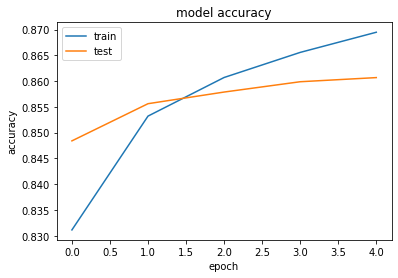

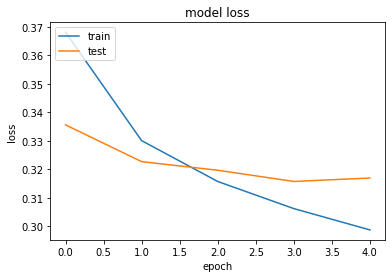

In [17]:
# summarize history for accuracy
plt.plot(results.history.history['accuracy'])
plt.plot(results.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model_acc_LSTM_lem.png')
plt.show()

# summarize history for loss
plt.plot(results.history.history['loss'])
plt.plot(results.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model_loss_LSTM_lem.png')
plt.show()

In [ ]:
!mv 'model_lstm_300_lem' 'drive/MyDrive/ML_project/'/ #place where we want to save our model 